In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore", message="The behavior of DataFrame concatenation with empty or all-NA entries")

Mean Squared Error (MSE): 68.60
R² Score: 0.00
Top 5 Features:
Frontal Pole Change         0.265245
Frontal Pole Volume Avg     0.123016
age at baseline             0.120375
Temporal Pole Volume Avg    0.074910
Occipital Pole Change       0.055318
dtype: float64


/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_89939/3927164745.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_features, y=top_5_features.index, palette='viridis', hue=None)


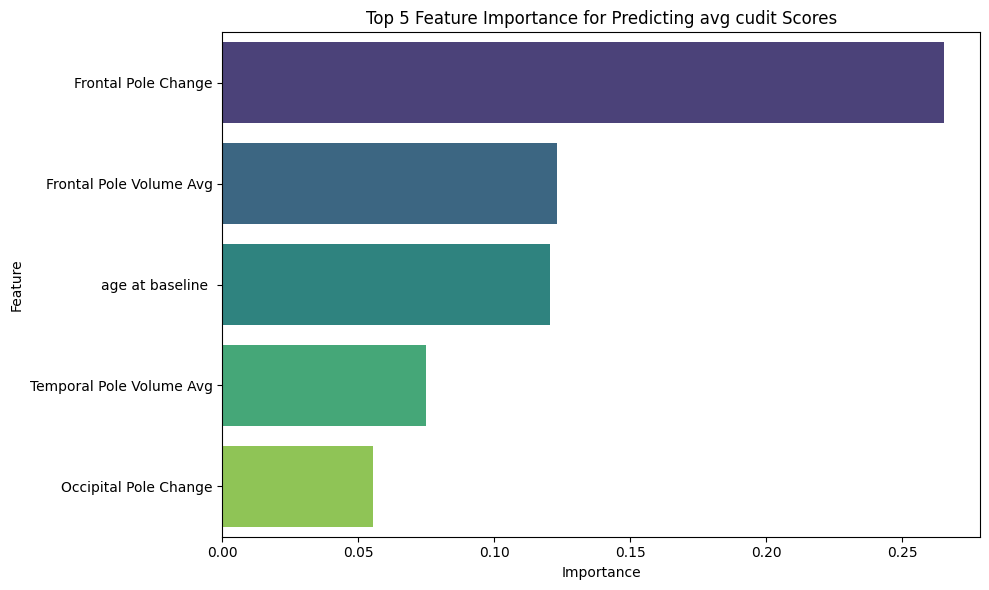

In [11]:
# Load the data
file_path = 'participants_with_changes.xlsx'  # Ensure the file is in the working directory
df = pd.read_excel(file_path)
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])

# Data Preprocessing
# Identify and encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

# Encode all categorical columns except the target
for col in categorical_cols:
    if col != 'avg cudit':  # Don't encode the target
        df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Remove other CUDIT columns from the features
# Exclude columns related to CUDIT scores from features
columns_to_exclude = [
    'gender', 'avg cudit', 'cudit total baseline', 'cudit total follow-up',
    'audit total baseline', 'audit total follow-up', 'participant_id', 
    'group', 'age at onset first CB use', 'age at onset frequent CB use',
    'age at baseline'
]
X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')  # Exclude irrelevant columns
y = df_encoded['avg cudit']

# Handle missing values by imputing with mean
X.fillna(X.mean(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predict and evaluate
y_pred = gbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature Importance
feature_importances = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 5 most important features
top_5_features = feature_importances.head(5)
print("Top 5 Features:")
print(top_5_features)

# Visualize Top 5 Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_features, y=top_5_features.index, palette='viridis', hue=None)
plt.title('Top 5 Feature Importance for Predicting avg cudit Scores')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [12]:
# Load the data
file_path = 'participants_with_changes.xlsx'  # Ensure this file is in the working directory
df = pd.read_excel(file_path)
df['avg cudit'] = (df['cudit total baseline'] + df['cudit total follow-up']) / 2

# Drop irrelevant columns
df = df.drop(columns=['Baseline File Path', 'Followup File Path'])

# Encode categorical columns and drop unnecessary columns
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

X = df_encoded.drop(columns=columns_to_exclude, errors='ignore')
y = df_encoded['avg cudit']

# Impute missing values with the mean
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Feature', 'MSE', 'R²', 'P-value'])

# Perform linear regression for each feature with significance testing
for feature in X_imputed.columns:
    # Prepare single feature for regression
    X_feature = X_imputed[[feature]]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Use statsmodels for significance testing
    X_feature_with_const = sm.add_constant(X_feature)  # Add intercept
    ols_model = sm.OLS(y, X_feature_with_const).fit()
    if len(ols_model.pvalues) > 1:  # Ensure the p-value for the feature exists
        p_value = ols_model.pvalues.iloc[1]
    else:
        p_value = np.nan
    
    new_row = pd.DataFrame({'Feature': [feature], 'MSE': [mse], 'R²': [r2], 'P-value': [p_value]})
    # Check if the new_row is valid before concatenating
    if not new_row.isna().all(axis=None) and not new_row.empty:
        results = pd.concat([results, new_row], ignore_index=True)

# Sort the results by R² in descending order
results = results.sort_values(by='R²', ascending=False)

# Display the results
print("Linear Regression Results with Significance Testing:")
print(results.head(10))

# Save results to Excel if needed
results.to_excel('linear_regression_with_significance.xlsx', index=False)

Linear Regression Results with Significance Testing:
                                               Feature        MSE        R²  \
134  Temporal Fusiform Cortex, posterior division C...  43.829640  0.361704   
131   Parahippocampal Gyrus, posterior division Change  50.272565  0.267875   
106  Superior Temporal Gyrus, posterior division Ch...  51.213345  0.254175   
122  Juxtapositional Lobule Cortex (formerly Supple...  51.329538  0.252482   
99                       Superior Frontal Gyrus Change  51.772705  0.246029   
103                            Precentral Gyrus Change  52.245009  0.239150   
111  Inferior Temporal Gyrus, posterior division Ch...  52.391115  0.237023   
136                    Occipital Fusiform Gyrus Change  52.797475  0.231105   
114                    Superior Parietal Lobule Change  52.848117  0.230367   
102    Inferior Frontal Gyrus, pars opercularis Change  53.046296  0.227481   

      P-value  
134  0.003882  
131  0.004605  
106  0.004235  
122  0.013701

/var/folders/90/qbmnblws2t16bv6092vjyq1r0000gn/T/ipykernel_89939/827856003.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


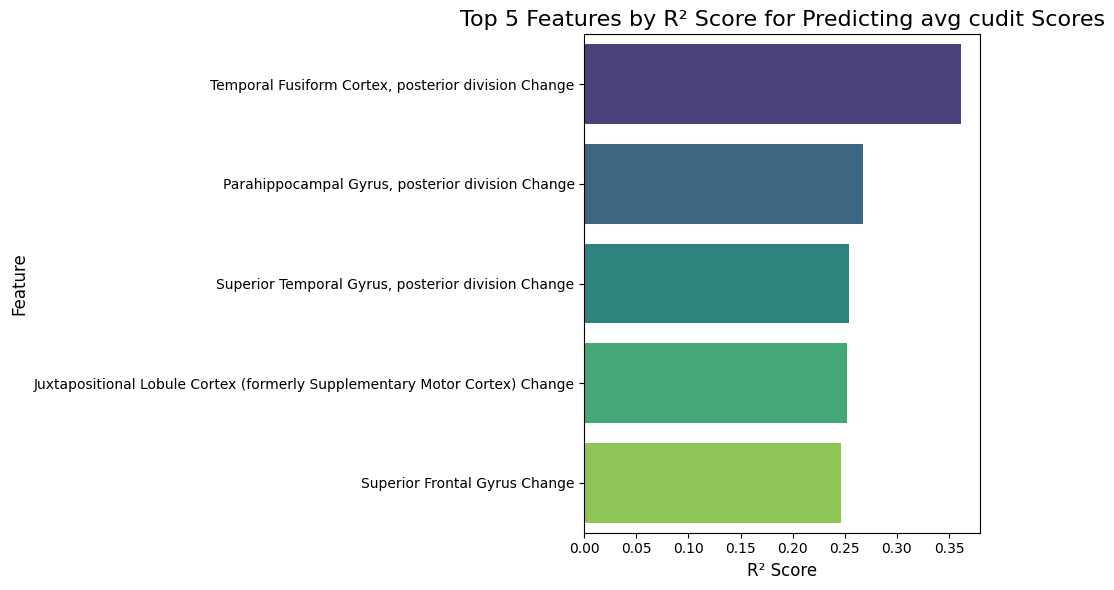

In [18]:
# Assuming 'results' DataFrame is already loaded and sorted by R² in descending order
# Select the top 5 features by R²
top_5_results = results.head(5)

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_5_results['R²'], 
    y=top_5_results['Feature'], 
    palette='viridis'
)

# Add title and labels
plt.title('Top 5 Features by R² Score for Predicting avg cudit Scores', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()